## LangGraph, capture user's input
This script is to capture the user's input and display it. This will demonstrate the Human-In-Loop (HIL) feature of LangGraph.

In [1]:
from typing import TypedDict,List
from langchain.schema import BaseMessage

# Define our state structure
class State(TypedDict):
    messages: List[BaseMessage]
    next_step: str

In [2]:
from langgraph.graph import StateGraph, END

# StateGraph
workflow = StateGraph(State)

# Node to ask the question
def ask_human(state: State) -> State:
    state["messages"].append({"role": "assistant", "content": "Hello! What's your name?"})
    state["next_step"] = "get_name"

    return state

def get_name(state: State) -> State:
    name = state["messages"][-1]["content"]
    state["messages"].append({"role": "assistant", "content": f"Nice to meet you, {name}! How can I assist you today?"})
    state["next_step"] = "end"
    return state


# Add nodes to workflow
workflow.add_node("ask_human", ask_human)
workflow.add_node("get_name", get_name)

# Lets wireup the node with start and end nodes
workflow.set_entry_point("ask_human")  # Pointing the _START_ node
workflow.add_edge("ask_human", "get_name") 
workflow.add_edge("get_name", END)  # Pointing the _END_ node

# All done, lets compile the workflow to make an app
graph = workflow.compile()

Now the workflow is compiled and ready for execution. We can visualize the workflow that we created to identify any mistages.

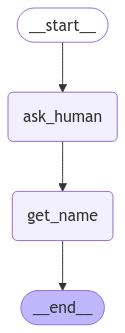

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Run the app/workflow

In [5]:
import uuid

init_state = {"next_step":"", "messages":[]}
config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}

for event in graph.stream(init_state, config):
    for output in event.values():
        if "messages" in output:
            for message in output["messages"]:
                if message["role"] == "assistant":
                    print(f"Assistant: {message['content']}")
                elif message["role"] == "human":
                    print(f"Human: {message['content']}")
    
    # Check if 'next_step' exists
    if "next_step" in output and output["next_step"] == "get_name":
        user_input = input("Your response: ")
        output["messages"].append({"role": "human", "content": user_input})
                    
print("End of workflow")

Assistant: Hello! What's your name?
Assistant: Hello! What's your name?
Human: Pradeep
Assistant: Nice to meet you, Pradeep! How can I assist you today?
End of workflow
